# Installation des extensions requises

Il est important d'inclure le le fichier requierement.txt
dans votre repertoire de travail soit indiquer le
chemin qui y mene vers le fichier requirement.txt.
Une fois que le chemin est bien renseigner, exécuter la commande suivante pour l'installation des bibliothèques

In [ ]:
pip install -r requirements.txt

# Import des bibliothèques

In [1]:
import os
import sys
import csv
import ntpath
# import nilearn
import numpy as np
import pandas as pd
import nibabel as nib
from glob import glob
import SimpleITK as sitk
import nibabel.processing
from radiomics import featureextractor
from tqdm import tqdm_notebook as tqdm

# Chemin vers les données

Les données sont zipé. Indiquer le chemin complet jusqu'aux données. Le dossier lesions comporte les images et masques avec des pondérations T2w et diffusion ADC en plus des données clinic du dataset ProstateX d'une taille de 202 données images patient en format NIFTI.

In [90]:
root_dir = "lesions/"

clin_info = os.path.join(root_dir, "PROSTATEx_Classes.csv")

In [91]:
df = pd.read_csv(clin_info)

# Visualisation des données du dataset

In [92]:
df.head(5)

,ID,Clinically Significant,Gleason_Grade_Group
0,ProstateX-0000_Finding1,True,3
1,ProstateX-0001_Finding1,False,1
2,ProstateX-0002_Finding1,True,2
3,ProstateX-0002_Finding2,False,1
4,ProstateX-0003_Finding1,False,No biopsy information


# Ploting des IRM de Prostate

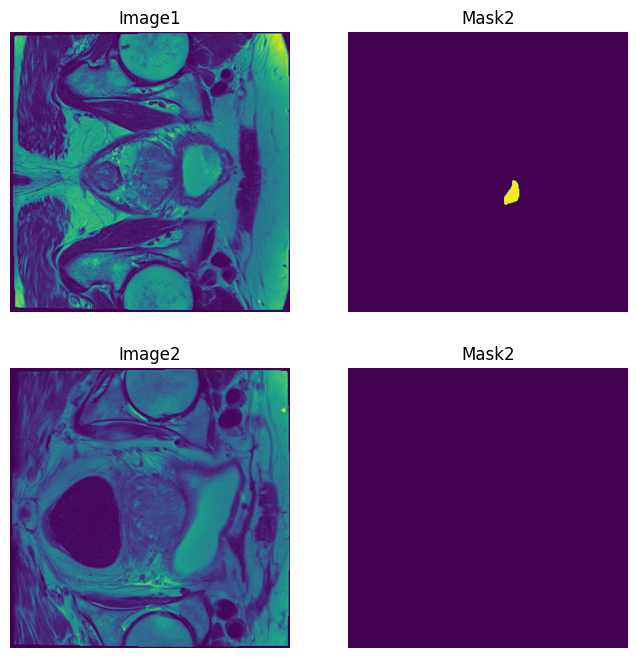

In [131]:
import random
import matplotlib.pyplot as plt

img_dir = "lesions/Images/T2/*"
msk_dir = "lesions/Masks/T2/*"

img = glob(img_dir)
msk = glob(msk_dir)

random_index1 = random.randint(0, len(img)-2)
random_index2 = random.randint(0, len(img)-2)

# print()

rand_img1 = nib.load(img[random_index1]).get_fdata()
rand_msk1 = nib.load(msk[random_index1]).get_fdata()

rand_img2 = nib.load(img[random_index2]).get_fdata()
rand_msk2 = nib.load(msk[random_index2]).get_fdata()

img1 = rand_img1[:,:,12]
msk1 = rand_msk1[:,:,12]

img2 = rand_img2[:,:,12]
msk2 = rand_msk2[:,:,12]

fig,axs = plt.subplots(2,2, figsize=(8,8))

axs[0, 0].imshow(img1)
axs[0, 0].set_title("Image1")
axs[0, 0].axis("off")

axs[0, 1].imshow(msk1)
axs[0, 1].set_title("Mask1")
axs[0, 1].axis("off")

axs[1, 0].imshow(img2)
axs[1, 0].set_title("Image2")
axs[1, 0].axis("off")

axs[1, 1].imshow(msk2)
axs[1, 1].set_title("Mask2")
axs[1, 1].axis("off")

plt.show()

# Taille du dataset

In [93]:
len(df)

299

# Suppression des données sans informations de biopsie

In [132]:
df_clif = pd.read_csv(clin_info) # Permet de regrouper les données en fonction de la colonne des infos clinic

df_clif.drop(df_clif[df_clif['Gleason_Grade_Group']=='No biopsy information'].index, inplace=True)
df_clif.drop(df_clif[df_clif['ID']=='ProstateX-0028_Finding1'].index, inplace = True)
df_clif.drop(df_clif[df_clif['ID']=='ProstateX-0002_Finding2'].index, inplace = True)
df_clif.drop(df_clif[df_clif['ID']=='ProstateX-0002_Finding1'].index, inplace = True)
df_clif.drop(df_clif[df_clif['ID']=='ProstateX-0031_Finding1'].index, inplace = True)
df_clif.drop(df_clif[df_clif['ID']=='ProstateX-0031_Finding2'].index, inplace = True)
df_clif.drop(df_clif[df_clif['ID']=='ProstateX-0128_Finding1'].index, inplace = True)

df_clif.drop(df_clif[df_clif['ID']=='Finding2'].index, inplace=True)

In [95]:
df_clif.head(5) # Visualisation des données apres suppression

,ID,Clinically Significant,Gleason_Grade_Group
0,ProstateX-0000_Finding1,True,3
1,ProstateX-0001_Finding1,False,1
6,ProstateX-0004_Finding1,False,1
7,ProstateX-0005_Finding0,True,2
8,ProstateX-0005_Finding1,True,3


In [96]:
len(df_clif) # Nouvelle taille des données après supression des données ne disposant pas d'information clinique 

106

# Création des groupes en fonction du grades de Gleason

A ce niveau nous regroupons les données en fontion du grade de Gleason à partir du dataframe df_clif

In [97]:
df = df_clif

#Grade 1 
GG1_Grp = df.groupby(df.Gleason_Grade_Group)
GG1 = GG1_Grp.get_group('1')

#Grade 2
GG2_Grp = df.groupby(df.Gleason_Grade_Group)
GG2 = GG1_Grp.get_group('2')

# Grade 3
GG3_Grp = df.groupby(df.Gleason_Grade_Group)
GG3 = GG1_Grp.get_group('3')

#Grade 4
GG4_Grp = df.groupby(df.Gleason_Grade_Group)
GG4 = GG1_Grp.get_group('4')

#Grade 5
GG5_Grp = df.groupby(df.Gleason_Grade_Group)
GG5 = GG1_Grp.get_group('5')

# Extraction des ID des patiens

Nous aloons récupérer à ce niveau les les indexes ou les ID(Identifiant) de chaque patients en fonction des grades dans des fichiers différents(GG1.txt, GG2.txt, ...., GG5.txt). 

NB: Indiquer le chemin correspondant à l'emplacement du dossier dans lequel vous allez effectuer la sauvegarde

In [98]:
GG1_dic = []
GG2_dic = []
GG3_dic = []
GG4_dic = []
GG5_dic = []

for gg1 in GG1['ID']:
    GG1_dic.append(gg1)
    gg1 = gg1.split('_')[0]
    txt_file = open('lesions/Patient_ID/GG1.txt', 'a')
    txt_file.write(gg1 + "\n")
    
for gg2 in GG2['ID']:
    GG2_dic.append(gg2)
    gg2 = gg2.split('_')[0]
    txt_file = open('lesions/Patient_ID/GG2.txt', 'a')
    txt_file.write(gg2 + "\n")
    
for gg3 in GG3['ID']:
    GG3_dic.append(gg3)
    gg3 = gg3.split('_')[0]
    txt_file = open('lesions/Patient_ID/GG3.txt', 'a')
    txt_file.write(gg3 + "\n")
    
for gg4 in GG4['ID']:
    GG4_dic.append(gg4)
    gg4 = gg4.split('_')[0]
    txt_file = open('lesions/Patient_ID/GG4.txt', 'a')
    txt_file.write(gg4 + "\n")
    
for gg5 in GG5['ID']:
    GG5_dic.append(gg5)
    gg5 = gg5.split('_')[0]
    txt_file = open('lesions/Patient_ID/GG5.txt', 'a')
    txt_file.write(gg5 + "\n")

A ce niveau , nous créons des liste pour récupérer les identifiants des patients sauvegarder des les dictionnaires et fichiers précedement crée

In [99]:
GG1_indexes = []
GG2_indexes = []
GG3_indexes = []
GG4_indexes = []
GG5_indexes = []

for img in GG1_dic:
    GG1_indexes.append(img.split('-')[-1].split('_')[0])

for img in GG2_dic:
    GG2_indexes.append(img.split('-')[-1].split('_')[0])

for img in GG3_dic:
    GG3_indexes.append(img.split('-')[-1].split('_')[0])

for img in GG4_dic:
    GG4_indexes.append(img.split('-')[-1].split('_')[0])

for img in GG5_dic:
    GG5_indexes.append(img.split('-')[-1].split('_')[0])

# Pretraitment

A ce niveau , nous définissons des fonction nous permettant de normaliser les données des images et leus masques

In [100]:
def correctBiasField(img_input, mask):
   

    corrected = False
    img_output = np.zeros(img_input.shape)

    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    inputImage = sitk.GetImageFromArray(img_input)
    maskImage = sitk.GetImageFromArray((mask > 0.9).astype(np.uint8))
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
    output = corrector.Execute(inputImage, maskImage)
    img_output = sitk.GetArrayFromImage(output)
    corrected = True
      
    return img_output


def filterMedian(img_input, perc):
    
    img_flattened = img_input.flatten()

    th_low = np.percentile(img_flattened, perc)
    th_up = np.percentile(img_flattened, 100 - perc)

    mask_low = img_input < th_low
    mask_up = img_input > th_up

    img_output = img_input * (1 - mask_up) + th_up * mask_up
    img_output = img_output * (1 - mask_low) + th_low * mask_low

    return img_output


def normROI(img_input, mask):
    
    mask_binary = (mask > 0.9).astype(int)
    mask_nan = mask_binary / mask_binary
    img_masked_nan = img_input * mask_nan

    m = np.nanmean(img_masked_nan)
    s = np.nanstd(img_masked_nan)

    img_output = (img_input - m) * mask_binary / s

    return img_output

# Bias Field Correction

Nous appliquons la fonction précedente à nos données et les nouvelles données image générer sont sauvegarder pour être utiliser pour extraire les caractéristiques radiomiques.

NB: Les dossier sont déjà disponible dans le dossier lesion comme indiquer dans le Readme.md, il ne restera qu'à exécuter le code après les pré-requis indiquer dans le readme

# GG1

 * ADC

In [101]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

adc_igm_dir = os.path.join(root_dir,"Images/ADC")
adc_msk_dir = os.path.join(root_dir,"Masks/ADC")

GG1_img_save = os.path.join(save_root_dir, "GG1/Images_Resamble/ADC")

for index in GG1_indexes:
    adc_img = glob(adc_igm_dir + '/*' + index + '*')[0]
    adc_img_nii = nib.load(adc_img)
    img = adc_img_nii.get_fdata()
    print("img-"+index+" : ",adc_img_nii.shape)

    adc_msk = glob(adc_msk_dir + '/*' + index + '*')[0]
    adc_msk_nii = nib.load(adc_msk)
    mask = adc_msk_nii.get_fdata()
    print("msk-"+index+" : ",adc_msk_nii.shape)
    
    adc_img_bfc = correctBiasField(img, mask)
    adc_img_bfc_nii = nib.Nifti1Image(adc_img_bfc, adc_img_nii.affine)
    print("img_norm-"+index+" : ",adc_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(adc_img_bfc_nii, os.path.join(GG1_img_save, ntpath.basename(adc_img)[:-17] + 'adc_preprocessed.nii'))
    
print('END of GG1')

img-0001 :  (84, 128, 19)
msk-0001 :  (84, 128, 19)
img_norm-0001 :  (84, 128, 19)
-------------------------
img-0004 :  (84, 128, 19)
msk-0004 :  (84, 128, 19)
img_norm-0004 :  (84, 128, 19)
-------------------------
img-0016 :  (84, 128, 21)
msk-0016 :  (84, 128, 21)
img_norm-0016 :  (84, 128, 21)
-------------------------
img-0053 :  (84, 128, 21)
msk-0053 :  (84, 128, 21)
img_norm-0053 :  (84, 128, 21)
-------------------------
img-0069 :  (84, 128, 19)
msk-0069 :  (84, 128, 19)
img_norm-0069 :  (84, 128, 19)
-------------------------
img-0076 :  (84, 128, 19)
msk-0076 :  (84, 128, 19)
img_norm-0076 :  (84, 128, 19)
-------------------------
img-0084 :  (84, 128, 19)
msk-0084 :  (84, 128, 19)
img_norm-0084 :  (84, 128, 19)
-------------------------
img-0101 :  (84, 128, 19)
msk-0101 :  (84, 128, 19)
img_norm-0101 :  (84, 128, 19)
-------------------------
img-0110 :  (84, 128, 19)
msk-0110 :  (84, 128, 19)
img_norm-0110 :  (84, 128, 19)
-------------------------
img-0116 :  (84, 12

 * T2

In [102]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

t2_igm_dir = os.path.join(root_dir,"Images/T2")
t2_msk_dir = os.path.join(root_dir,"Masks/T2")

GG1_img_save = os.path.join(save_root_dir, "GG1/Images_Resamble/T2")

for index in GG1_indexes:
    t2_img = glob(t2_igm_dir + '/*' + index + '*')[0]
    t2_img_nii = nib.load(t2_img)
    img = t2_img_nii.get_fdata()
    print("img-"+index+" : ",t2_img_nii.shape)

    t2_msk = glob(t2_msk_dir + '/*' + index + '*')[0]
    t2_msk_nii = nib.load(t2_msk)
    mask = t2_msk_nii.get_fdata()
    print("msk-"+index+" : ",t2_msk_nii.shape)
    
    t2_img_bfc = correctBiasField(img, mask)
    t2_img_bfc_nii = nib.Nifti1Image(t2_img_bfc, t2_img_nii.affine)
    print("img_norm-"+index+" : ",t2_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(t2_img_bfc_nii, os.path.join(GG1_img_save, ntpath.basename(t2_img)[:-14] + '_preprocessed.nii'))
    
print('END of GG1')

img-0001 :  (384, 384, 19)
msk-0001 :  (384, 384, 19)
img_norm-0001 :  (384, 384, 19)
-------------------------
img-0004 :  (384, 384, 19)
msk-0004 :  (384, 384, 19)
img_norm-0004 :  (384, 384, 19)
-------------------------
img-0016 :  (384, 384, 21)
msk-0016 :  (384, 384, 21)
img_norm-0016 :  (384, 384, 21)
-------------------------
img-0053 :  (384, 384, 21)
msk-0053 :  (384, 384, 21)
img_norm-0053 :  (384, 384, 21)
-------------------------
img-0069 :  (384, 384, 19)
msk-0069 :  (384, 384, 19)
img_norm-0069 :  (384, 384, 19)
-------------------------
img-0076 :  (384, 384, 19)
msk-0076 :  (384, 384, 19)
img_norm-0076 :  (384, 384, 19)
-------------------------
img-0084 :  (384, 384, 19)
msk-0084 :  (384, 384, 19)
img_norm-0084 :  (384, 384, 19)
-------------------------
img-0101 :  (320, 320, 19)
msk-0101 :  (320, 320, 19)
img_norm-0101 :  (320, 320, 19)
-------------------------
img-0110 :  (384, 384, 19)
msk-0110 :  (384, 384, 19)
img_norm-0110 :  (384, 384, 19)
------------------

GG2

* ADC

In [103]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

adc_igm_dir = os.path.join(root_dir,"Images/ADC")
adc_msk_dir = os.path.join(root_dir,"Masks/ADC")

GG2_img_save = os.path.join(save_root_dir, "GG2/Images_Resamble/ADC")

for index in GG2_indexes:
    adc_img = glob(adc_igm_dir + '/*' + index + '*')[0]
    adc_img_nii = nib.load(adc_img)
    img = adc_img_nii.get_fdata()
    print("img-"+index+" : ",adc_img_nii.shape)

    adc_msk = glob(adc_msk_dir + '/*' + index + '*')[0]
    adc_msk_nii = nib.load(adc_msk)
    mask = adc_msk_nii.get_fdata()
    print("msk-"+index+" : ",adc_msk_nii.shape)
    
    adc_img_bfc = correctBiasField(img, mask)
    adc_img_bfc_nii = nib.Nifti1Image(adc_img_bfc, adc_img_nii.affine)
    print("img_norm-"+index+" : ",adc_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(adc_img_bfc_nii, os.path.join(GG2_img_save, ntpath.basename(adc_img)[:-17] + 'adc_preprocessed.nii'))
    
print('END of GG2')

img-0005 :  (84, 128, 19)
msk-0005 :  (84, 128, 19)
img_norm-0005 :  (84, 128, 19)
-------------------------
img-0014 :  (84, 128, 19)
msk-0014 :  (84, 128, 19)
img_norm-0014 :  (84, 128, 19)
-------------------------
img-0018 :  (84, 128, 19)
msk-0018 :  (84, 128, 19)
img_norm-0018 :  (84, 128, 19)
-------------------------
img-0019 :  (84, 128, 19)
msk-0019 :  (84, 128, 19)
img_norm-0019 :  (84, 128, 19)
-------------------------
img-0035 :  (84, 128, 19)
msk-0035 :  (84, 128, 19)
img_norm-0035 :  (84, 128, 19)
-------------------------
img-0037 :  (84, 128, 19)
msk-0037 :  (84, 128, 19)
img_norm-0037 :  (84, 128, 19)
-------------------------
img-0040 :  (84, 128, 19)
msk-0040 :  (84, 128, 19)
img_norm-0040 :  (84, 128, 19)
-------------------------
img-0041 :  (84, 128, 19)
msk-0041 :  (84, 128, 19)
img_norm-0041 :  (84, 128, 19)
-------------------------
img-0054 :  (84, 128, 19)
msk-0054 :  (84, 128, 19)
img_norm-0054 :  (84, 128, 19)
-------------------------
img-0067 :  (84, 12

* T2

In [104]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

t2_igm_dir = os.path.join(root_dir,"Images/T2")
t2_msk_dir = os.path.join(root_dir,"Masks/T2")

GG2_img_save = os.path.join(save_root_dir, "GG2/Images_Resamble/T2")

for index in GG2_indexes:
    t2_img = glob(t2_igm_dir + '/*' + index + '*')[0]
    t2_img_nii = nib.load(t2_img)
    img = t2_img_nii.get_fdata()
    print("img-"+index+" : ",t2_img_nii.shape)
    
    t2_msk = glob(t2_msk_dir + '/*' + index + '*')[0]
    t2_msk_nii = nib.load(t2_msk)
    mask = t2_msk_nii.get_fdata()
    print("msk-"+index+" : ",t2_msk_nii.shape)
    
    t2_img_bfc = correctBiasField(img, mask)
    t2_img_bfc_nii = nib.Nifti1Image(t2_img_bfc, t2_img_nii.affine)
    print("img_norm-"+index+" : ",t2_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(t2_img_bfc_nii, os.path.join(GG2_img_save, ntpath.basename(t2_img)[:-14] + '_preprocessed.nii'))
    
print('END of GG2')

img-0005 :  (384, 384, 19)
msk-0005 :  (384, 384, 19)
img_norm-0005 :  (384, 384, 19)
-------------------------
img-0014 :  (384, 384, 19)
msk-0014 :  (384, 384, 19)
img_norm-0014 :  (384, 384, 19)
-------------------------
img-0018 :  (384, 384, 19)
msk-0018 :  (384, 384, 19)
img_norm-0018 :  (384, 384, 19)
-------------------------
img-0019 :  (384, 384, 19)
msk-0019 :  (384, 384, 19)
img_norm-0019 :  (384, 384, 19)
-------------------------
img-0035 :  (384, 384, 19)
msk-0035 :  (384, 384, 19)
img_norm-0035 :  (384, 384, 19)
-------------------------
img-0037 :  (384, 384, 19)
msk-0037 :  (384, 384, 19)
img_norm-0037 :  (384, 384, 19)
-------------------------
img-0040 :  (384, 384, 19)
msk-0040 :  (384, 384, 19)
img_norm-0040 :  (384, 384, 19)
-------------------------
img-0041 :  (384, 384, 21)
msk-0041 :  (384, 384, 21)
img_norm-0041 :  (384, 384, 21)
-------------------------
img-0054 :  (320, 320, 21)
msk-0054 :  (320, 320, 21)
img_norm-0054 :  (320, 320, 21)
------------------

GG3

* ADC

In [105]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

adc_igm_dir = os.path.join(root_dir,"Images/ADC")
adc_msk_dir = os.path.join(root_dir,"Masks/ADC")

GG3_img_save = os.path.join(save_root_dir, "GG3/Images_Resamble/ADC")

for index in GG3_indexes:
    adc_img = glob(adc_igm_dir + '/*' + index + '*')[0]
    adc_img_nii = nib.load(adc_img)
    img = adc_img_nii.get_fdata()
    print("img-"+index+" : ",adc_img_nii.shape)

    adc_msk = glob(adc_msk_dir + '/*' + index + '*')[0]
    adc_msk_nii = nib.load(adc_msk)
    mask = adc_msk_nii.get_fdata()
    print("msk-"+index+" : ",adc_msk_nii.shape)
    
    adc_img_bfc = correctBiasField(img, mask)
    adc_img_bfc_nii = nib.Nifti1Image(adc_img_bfc, adc_img_nii.affine)
    print("img_norm-"+index+" : ",adc_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(adc_img_bfc_nii, os.path.join(GG3_img_save, ntpath.basename(adc_img)[:-17] + 'adc_preprocessed.nii'))
    
print('END of GG3')

img-0000 :  (84, 128, 19)
msk-0000 :  (84, 128, 19)
img_norm-0000 :  (84, 128, 19)
-------------------------
img-0005 :  (84, 128, 19)
msk-0005 :  (84, 128, 19)
img_norm-0005 :  (84, 128, 19)
-------------------------
img-0015 :  (84, 128, 19)
msk-0015 :  (84, 128, 19)
img_norm-0015 :  (84, 128, 19)
-------------------------
img-0046 :  (84, 128, 19)
msk-0046 :  (84, 128, 19)
img_norm-0046 :  (84, 128, 19)
-------------------------
img-0055 :  (84, 128, 19)
msk-0055 :  (84, 128, 19)
img_norm-0055 :  (84, 128, 19)
-------------------------
img-0071 :  (84, 128, 19)
msk-0071 :  (84, 128, 19)
img_norm-0071 :  (84, 128, 19)
-------------------------
img-0078 :  (84, 128, 19)
msk-0078 :  (84, 128, 19)
img_norm-0078 :  (84, 128, 19)
-------------------------
img-0092 :  (84, 128, 19)
msk-0092 :  (84, 128, 19)
img_norm-0092 :  (84, 128, 19)
-------------------------
img-0094 :  (84, 128, 19)
msk-0094 :  (84, 128, 19)
img_norm-0094 :  (84, 128, 19)
-------------------------
img-0095 :  (84, 12

* T2

In [106]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

t2_igm_dir = os.path.join(root_dir,"Images/T2")
t2_msk_dir = os.path.join(root_dir,"Masks/T2")

GG3_img_save = os.path.join(save_root_dir, "GG3/Images_Resamble/T2")

for index in GG3_indexes:
    t2_img = glob(t2_igm_dir + '/*' + index + '*')[0]
    t2_img_nii = nib.load(t2_img)
    img = t2_img_nii.get_fdata()
    print("img-"+index+" : ",t2_img_nii.shape)
    
    t2_msk = glob(t2_msk_dir + '/*' + index + '*')[0]
    t2_msk_nii = nib.load(t2_msk)
    mask = t2_msk_nii.get_fdata()
    print("msk-"+index+" : ",t2_msk_nii.shape)
    
    t2_img_bfc = correctBiasField(img, mask)
    t2_img_bfc_nii = nib.Nifti1Image(t2_img_bfc, t2_img_nii.affine)
    print("img_norm-"+index+" : ",t2_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(t2_img_bfc_nii, os.path.join(GG3_img_save, ntpath.basename(t2_img)[:-14] + '_preprocessed.nii'))
    
print('END of GG3')

img-0000 :  (384, 384, 19)
msk-0000 :  (384, 384, 19)
img_norm-0000 :  (384, 384, 19)
-------------------------
img-0005 :  (384, 384, 19)
msk-0005 :  (384, 384, 19)
img_norm-0005 :  (384, 384, 19)
-------------------------
img-0015 :  (384, 384, 19)
msk-0015 :  (384, 384, 19)
img_norm-0015 :  (384, 384, 19)
-------------------------
img-0046 :  (384, 384, 19)
msk-0046 :  (384, 384, 19)
img_norm-0046 :  (384, 384, 19)
-------------------------
img-0055 :  (384, 384, 19)
msk-0055 :  (384, 384, 19)
img_norm-0055 :  (384, 384, 19)
-------------------------
img-0071 :  (384, 384, 19)
msk-0071 :  (384, 384, 19)
img_norm-0071 :  (384, 384, 19)
-------------------------
img-0078 :  (384, 384, 19)
msk-0078 :  (384, 384, 19)
img_norm-0078 :  (384, 384, 19)
-------------------------
img-0092 :  (384, 384, 19)
msk-0092 :  (384, 384, 19)
img_norm-0092 :  (384, 384, 19)
-------------------------
img-0094 :  (384, 384, 19)
msk-0094 :  (384, 384, 19)
img_norm-0094 :  (384, 384, 19)
------------------

In [107]:
GG4

,ID,Clinically Significant,Gleason_Grade_Group
32,ProstateX-0026_Finding1,True,4
99,ProstateX-0077_Finding1,True,4
172,ProstateX-0126_Finding2,True,4
277,ProstateX-0192_Finding1,True,4
284,ProstateX-0195_Finding1,True,4
290,ProstateX-0199_Finding1,True,4
291,ProstateX-0199_Finding2,True,4
295,ProstateX-0202_Finding1,True,4


* ADC

In [108]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

adc_igm_dir = os.path.join(root_dir,"Images/ADC")
adc_msk_dir = os.path.join(root_dir,"Masks/ADC")

GG4_img_save = os.path.join(save_root_dir, "GG4/Images_Resamble/ADC")

for index in GG4_indexes:
    adc_img = glob(adc_igm_dir + '/*' + index + '*')[0]
    adc_img_nii = nib.load(adc_img)
    img = adc_img_nii.get_fdata()
    print("img-"+index+" : ",adc_img_nii.shape)

    adc_msk = glob(adc_msk_dir + '/*' + index + '*')[0]
    adc_msk_nii = nib.load(adc_msk)
    mask = adc_msk_nii.get_fdata()
    print("msk-"+index+" : ",adc_msk_nii.shape)
    
    adc_img_bfc = correctBiasField(img, mask)
    adc_img_bfc_nii = nib.Nifti1Image(adc_img_bfc, adc_img_nii.affine)
    print("img_norm-"+index+" : ",adc_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(adc_img_bfc_nii, os.path.join(GG4_img_save, ntpath.basename(adc_img)[:-17] + 'adc_preprocessed.nii'))
    
print('END of GG4')

img-0026 :  (84, 128, 19)
msk-0026 :  (84, 128, 19)
img_norm-0026 :  (84, 128, 19)
-------------------------
img-0077 :  (84, 128, 19)
msk-0077 :  (84, 128, 19)
img_norm-0077 :  (84, 128, 19)
-------------------------
img-0126 :  (84, 128, 19)
msk-0126 :  (84, 128, 19)
img_norm-0126 :  (84, 128, 19)
-------------------------
img-0192 :  (120, 128, 19)
msk-0192 :  (120, 128, 19)
img_norm-0192 :  (120, 128, 19)
-------------------------
img-0195 :  (120, 128, 19)
msk-0195 :  (120, 128, 19)
img_norm-0195 :  (120, 128, 19)
-------------------------
img-0199 :  (128, 106, 20)
msk-0199 :  (128, 106, 20)
img_norm-0199 :  (128, 106, 20)
-------------------------
img-0199 :  (128, 106, 20)
msk-0199 :  (128, 106, 20)
img_norm-0199 :  (128, 106, 20)
-------------------------
img-0202 :  (128, 106, 20)
msk-0202 :  (128, 106, 20)
img_norm-0202 :  (128, 106, 20)
-------------------------
END of GG4


* T2

In [109]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

t2_igm_dir = os.path.join(root_dir,"Images/T2")
t2_msk_dir = os.path.join(root_dir,"Masks/T2")

GG4_img_save = os.path.join(save_root_dir, "GG4/Images_Resamble/T2")

for index in GG4_indexes:
    t2_img = glob(t2_igm_dir + '/*' + index + '*')[0]
    t2_img_nii = nib.load(t2_img)
    img = t2_img_nii.get_fdata()
    print("img-"+index+" : ",t2_img_nii.shape)

    t2_msk = glob(t2_msk_dir + '/*' + index + '*')[0]
    t2_msk_nii = nib.load(t2_msk)
    mask = t2_msk_nii.get_fdata()
    print("msk-"+index+" : ",t2_msk_nii.shape)
    
    t2_img_bfc = correctBiasField(img, mask)
    t2_img_bfc_nii = nib.Nifti1Image(t2_img_bfc, t2_img_nii.affine)
    print("img_norm-"+index+" : ",t2_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(t2_img_bfc_nii, os.path.join(GG4_img_save, ntpath.basename(t2_img)[:-14] + '_preprocessed.nii'))
    
print('END of GG4')

img-0026 :  (384, 384, 21)
msk-0026 :  (384, 384, 21)
img_norm-0026 :  (384, 384, 21)
-------------------------
img-0077 :  (384, 384, 19)
msk-0077 :  (384, 384, 19)
img_norm-0077 :  (384, 384, 19)
-------------------------
img-0126 :  (384, 384, 23)
msk-0126 :  (384, 384, 23)
img_norm-0126 :  (384, 384, 23)
-------------------------
img-0192 :  (384, 384, 19)
msk-0192 :  (384, 384, 19)
img_norm-0192 :  (384, 384, 19)
-------------------------
img-0195 :  (384, 384, 19)
msk-0195 :  (384, 384, 19)
img_norm-0195 :  (384, 384, 19)
-------------------------
img-0199 :  (320, 320, 19)
msk-0199 :  (320, 320, 19)
img_norm-0199 :  (320, 320, 19)
-------------------------
img-0199 :  (320, 320, 19)
msk-0199 :  (320, 320, 19)
img_norm-0199 :  (320, 320, 19)
-------------------------
img-0202 :  (320, 320, 21)
msk-0202 :  (320, 320, 21)
img_norm-0202 :  (320, 320, 21)
-------------------------
END of GG4


In [110]:
GG5

,ID,Clinically Significant,Gleason_Grade_Group
136,ProstateX-0103_Finding1,True,5
180,ProstateX-0131_Finding1,True,5
259,ProstateX-0181_Finding1,True,5
285,ProstateX-0196_Finding1,True,5
286,ProstateX-0196_Finding2,True,5
289,ProstateX-0198_Finding1,True,5
292,ProstateX-0200_Finding1,True,5


* ADC

In [111]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

adc_igm_dir = os.path.join(root_dir,"Images/ADC")
adc_msk_dir = os.path.join(root_dir,"Masks/ADC")

GG5_img_save = os.path.join(save_root_dir, "GG5/Images_Resamble/ADC")

for index in GG5_indexes:
    adc_img = glob(adc_igm_dir + '/*' + index + '*')[0]
    adc_img_nii = nib.load(adc_img)
    img = adc_img_nii.get_fdata()
    print("img-"+index+" : ",adc_img_nii.shape)

    adc_msk = glob(adc_msk_dir + '/*' + index + '*')[0]
    adc_msk_nii = nib.load(adc_msk)
    mask = adc_msk_nii.get_fdata()
    print("msk-"+index+" : ",adc_msk_nii.shape)
    
    adc_img_bfc = correctBiasField(img, mask)
    adc_img_bfc_nii = nib.Nifti1Image(adc_img_bfc, adc_img_nii.affine)
    print("img_norm-"+index+" : ",adc_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(adc_img_bfc_nii, os.path.join(GG5_img_save, ntpath.basename(adc_img)[:-17] + 'adc_preprocessed.nii'))
    
print('END of GG5')

img-0103 :  (84, 128, 19)
msk-0103 :  (84, 128, 19)
img_norm-0103 :  (84, 128, 19)
-------------------------
img-0131 :  (84, 128, 19)
msk-0131 :  (84, 128, 19)
img_norm-0131 :  (84, 128, 19)
-------------------------
img-0181 :  (84, 128, 25)
msk-0181 :  (84, 128, 25)
img_norm-0181 :  (84, 128, 25)
-------------------------
img-0196 :  (120, 128, 19)
msk-0196 :  (120, 128, 19)
img_norm-0196 :  (120, 128, 19)
-------------------------
img-0196 :  (120, 128, 19)
msk-0196 :  (120, 128, 19)
img_norm-0196 :  (120, 128, 19)
-------------------------
img-0198 :  (120, 128, 19)
msk-0198 :  (120, 128, 19)
img_norm-0198 :  (120, 128, 19)
-------------------------
img-0200 :  (128, 106, 20)
msk-0200 :  (128, 106, 20)
img_norm-0200 :  (128, 106, 20)
-------------------------
END of GG5


* T2

In [112]:
#Chemin vers nos données images et masques
root_dir = "lesions"

#Chemin de sauvegarde des données normalisés
save_root_dir = "lesions/Img_msk_resambled"

t2_igm_dir = os.path.join(root_dir,"Images/T2")
t2_msk_dir = os.path.join(root_dir,"Masks/T2")

GG5_img_save = os.path.join(save_root_dir, "GG5/Images_Resamble/T2")

for index in GG5_indexes:
    t2_img = glob(t2_igm_dir + '/*' + index + '*')[0]
    t2_img_nii = nib.load(t2_img)
    img = t2_img_nii.get_fdata()
    print("img-"+index+" : ",t2_img_nii.shape)

    t2_msk = glob(t2_msk_dir + '/*' + index + '*')[0]
    t2_msk_nii = nib.load(t2_msk)
    mask = t2_msk_nii.get_fdata()
    print("msk-"+index+" : ",t2_msk_nii.shape)
    
    
    t2_img_bfc = correctBiasField(img, mask)
    t2_img_bfc_nii = nib.Nifti1Image(t2_img_bfc, t2_img_nii.affine)
    print("img_norm-"+index+" : ",t2_img_bfc_nii.shape)
    print('-------------------------')
    nib.save(t2_img_bfc_nii, os.path.join(GG5_img_save, ntpath.basename(t2_img)[:-14] + '_preprocessed.nii'))
    
print('END of GG5')

img-0103 :  (384, 384, 21)
msk-0103 :  (384, 384, 21)
img_norm-0103 :  (384, 384, 21)
-------------------------
img-0131 :  (384, 384, 19)
msk-0131 :  (384, 384, 19)
img_norm-0131 :  (384, 384, 19)
-------------------------
img-0181 :  (384, 384, 25)
msk-0181 :  (384, 384, 25)
img_norm-0181 :  (384, 384, 25)
-------------------------
img-0196 :  (384, 384, 21)
msk-0196 :  (384, 384, 21)
img_norm-0196 :  (384, 384, 21)
-------------------------
img-0196 :  (384, 384, 21)
msk-0196 :  (384, 384, 21)
img_norm-0196 :  (384, 384, 21)
-------------------------
img-0198 :  (384, 384, 19)
msk-0198 :  (384, 384, 19)
img_norm-0198 :  (384, 384, 19)
-------------------------
img-0200 :  (320, 320, 21)
msk-0200 :  (320, 320, 21)
img_norm-0200 :  (320, 320, 21)
-------------------------
END of GG5


# Features extractions

Dans cette partie nous allons extraire les caractéristiques radiomique en fonctions des grades 

In [113]:
def extractFeatures(img_input, mask):

    i = sitk.GetImageFromArray(img_input) #Chargement des images et masques sous forme matriciel
    m = sitk.GetImageFromArray(mask)
    f_v = {}  # Initialisation de dictionnaire

    #Création de dictionnaire d'initialisation
    settings = {}
    settings['preCrop'] = True
    settings['normalize'] = False
    settings['binCount'] = 50
    settings['resampledPixelSpacing'] = None
    settings['interpolator'] = sitk.sitkBSpline

    #Variable d'extraction de features radiomics à partir de featureextractor de la bibliothèque PyRadiomic
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    
    extractor.addProvenance(False)
    extractor.disableAllFeatures()
    extractor.enableImageTypes(Original={})

    # Définition des différentes caractéristiques à extraire
    extractor.enableFeatureClassByName('firstorder', enabled=True)
    extractor.enableFeatureClassByName('shape', enabled=True)
    extractor.enableFeatureClassByName('glcm', enabled=True)
    extractor.enableFeatureClassByName('glrlm', enabled=True)
    extractor.enableFeatureClassByName('glszm', enabled=True)
    extractor.enableFeatureClassByName('gldm', enabled=True)
    extractor.enableFeatureClassByName('ngtdm', enabled=True)

    # Passage de l'image et du masque pour l'extraction
    extracted_ftrs = extractor.execute(i, m)

    # Définition de la clef et valeur pour les caractéristiques à extraire
    for key, value in extracted_ftrs.items():
        f_v[key] = value

    return f_v

In [114]:
# Cette fontion permet de créer les en-tête des colonnes

def createHeader():
    
    f = {'sub': ''}
    i_t = np.ones((2, 2, 2))
    m_t = np.zeros((2, 2, 2))
    m_t[0, 0, 0] = 1
    m_t[1, 1, 1] = 1
    f.update(extractFeatures(i_t, m_t))

    return list(f.keys())

In [115]:
#Fonction d'extraction proprement dite

def extractFromeTissuesThroughSubFolders(ds_folder, ds_names, 
                                         adc_modality = 'ADC', 
                                         t2_modality = 'T2'):
    
    gg = ds_folder.split('/')[-2]
    
    h = createHeader()
    
    # Dossier pour sauvegarder les caractéristiques extraits
    root_dir = 'lesions/ADC_T2_Images_Analyses/ADC_T2_features/'
    
    mask_dir = 'lesions/'
    
    #ouverture du fichier avec option ajout 'a' si le fichier n'existe pas
    adc_csv_file = open(root_dir  + gg + '_' + adc_modality + '_features.csv' , 'a')
    
    #Ecriture des caractéristiquex extraits dans le fichier créer
    adc_writer = csv.DictWriter(adc_csv_file, fieldnames = h, lineterminator='\n')
    adc_writer.writeheader()
    
    #ouverture du fichier avec option ajout 'a' si le fichier n'existe pas
    t2_csv_file = open(root_dir + gg + '_' + t2_modality + '_features.csv' , 'a')
    
    #Ecriture des caractéristiquex extraits dans le fichier créer
    t2_writer = csv.DictWriter(t2_csv_file, fieldnames = h, lineterminator='\n')
    t2_writer.writeheader()
    
    with tqdm(total=len(ds_names), file=sys.stdout) as pbar:        
        for sub in ds_names: #ds_name représente les indexes des patients regrouper précédement en fonction des grades

            #Chargement des images normalisées ADC  
            adc_img_path = ds_folder + "Images_Resamble/" + adc_modality + '/ProstateX-' + sub +'_ep2d_adc_preprocessed.nii'
            adc_img_nii = nib.load(adc_img_path)
            adc_img =adc_img_nii.get_fdata()
    
            # Chargement des images normalisées T2  
            t2_img_path = ds_folder + "Images_Resamble/" + t2_modality + '/ProstateX-' + sub +'_preprocessed.nii'
            t2_img_nii = nib.load(t2_img_path)
            t2_img =t2_img_nii.get_fdata()
                
            # Chargement des masques ADC pour chaque image. C'est l'importances des indexes d'images qui nous permettent
            # d'utiliser pour chaque image le masque correspondant
            adc_roi_path = mask_dir + 'Masks/'  + adc_modality + '/ProstateX-' + sub + '-Finding_ADC.nii.gz'                         
            adc_roi_nii = nib.load(adc_roi_path)
            adc_roi = adc_roi_nii.get_fdata()
            
            # Chargement des masques T2
            t2_roi_path = mask_dir + 'Masks/'  + t2_modality + '/ProstateX-' + sub + '-Finding-t2_ROI.nii.gz'                         
            t2_roi_nii = nib.load(t2_roi_path)
            t2_roi = t2_roi_nii.get_fdata()
            
            adc_img_preproc = np.copy(adc_img)
            t2_img_preproc = np.copy(t2_img)
            
            # Création de la colonne Sub à qui on affecte l'index qui représente l'ID du patient
            # précéder de ProstateX
            f_sub_adc = {'sub': 'ProstateX_' + str(sub)}
            # Association du f_sub_adc créer aux carractéristiques extraits pour chaque patient
            f_sub_adc.update(extractFeatures(adc_img_preproc, adc_roi))
            adc_writer.writerow(f_sub_adc)
            
            f_sub_t2 = {'sub': 'ProstateX_' + str(sub)}
            f_sub_t2.update(extractFeatures(t2_img_preproc, t2_roi))
            t2_writer.writerow(f_sub_t2)

            pbar.set_description('processed: %s' % sub)
            pbar.update(1)


    adc_csv_file.close()
    t2_csv_file.close()

In [116]:
root = 'lesions/Img_msk_resambled'

ds1_folder = os.path.join(root, 'GG1/')
ds2_folder = os.path.join(root, 'GG2/')
ds3_folder = os.path.join(root, 'GG3/')
ds4_folder = os.path.join(root, 'GG4/')
ds5_folder = os.path.join(root, 'GG5/')

J'ai deux modalités d'images à extraire

* Modalité T2

* Modalité ADC (Diffusion)

# GG1

In [117]:
extractFromeTissuesThroughSubFolders( ds1_folder, GG1_indexes)

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_28497/949791868.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(ds_names), file=sys.stdout) as pbar:


  0%|          | 0/34 [00:00<?, ?it/s]

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

# GG2

In [118]:
extractFromeTissuesThroughSubFolders( ds2_folder, GG2_indexes)

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_28497/949791868.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(ds_names), file=sys.stdout) as pbar:


  0%|          | 0/37 [00:00<?, ?it/s]

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

# GG3

In [119]:
extractFromeTissuesThroughSubFolders( ds3_folder, GG3_indexes)

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_28497/949791868.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(ds_names), file=sys.stdout) as pbar:


  0%|          | 0/20 [00:00<?, ?it/s]

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

# GG4

In [120]:
extractFromeTissuesThroughSubFolders( ds4_folder, GG4_indexes)

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_28497/949791868.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(ds_names), file=sys.stdout) as pbar:


  0%|          | 0/8 [00:00<?, ?it/s]

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

# GG5

In [121]:
extractFromeTissuesThroughSubFolders( ds5_folder, GG5_indexes)

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_28497/949791868.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(ds_names), file=sys.stdout) as pbar:


  0%|          | 0/7 [00:00<?, ?it/s]

Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Fixed bin Count enabled! However, we recommend using a fixed bin Width. See http://pyradiomics.readthedocs.io/en/latest/faq.html#radiomics-fixed-bin-width for more details
GLCM is symmetrical, therefore

# Features merging

Dans cette section nous allons concatener l'ensemble des datasets des 5 grades obtenus par extraction précédente

In [16]:
root_dir = "lesions/ADC_T2_Images_Analyses/ADC_T2_features/"  #Chemin vers les fichiers contenant les données extraient

# Ajout de la colonne ggs (Gleason Score Grad) pour chaque fichier contenant chacun un grade spécifique. Comme dit plus 
# haut, on a des données à la fois de séquence de diffusion T2W et ADC

# Ajout de la collonne ggs = 1
adc_gg1 = os.path.join(root_dir, "GG1_ADC_features.csv")
adc_gg1 = pd.read_csv(adc_gg1)
adc_gg1["ggs"]=1
adc_gg1.to_csv(root_dir + "GGS_GG1_ADC_features.csv")

# Ajout de la collonne ggs = 2
adc_gg2 = os.path.join(root_dir, "GG2_ADC_features.csv")
adc_gg2 = pd.read_csv(adc_gg2)
adc_gg2["ggs"]=2
adc_gg2.to_csv(root_dir + "GGS_GG2_ADC_features.csv")

# Ajout de la collonne ggs = 3
adc_gg3 = os.path.join(root_dir, "GG3_ADC_features.csv")
adc_gg3 = pd.read_csv(adc_gg3)
adc_gg3["ggs"]=3
adc_gg3.to_csv(root_dir + "GGS_GG3_ADC_features.csv")

# Ajout de la collonne ggs = 4
adc_gg4 = os.path.join(root_dir, "GG4_ADC_features.csv")
adc_gg4 = pd.read_csv(adc_gg4)
adc_gg4["ggs"]=4
adc_gg4.to_csv(root_dir + "GGS_GG4_ADC_features.csv")

# Ajout de la collonne ggs = 5
adc_gg5 = os.path.join(root_dir, "GG5_ADC_features.csv")
adc_gg5 = pd.read_csv(adc_gg5)
adc_gg5["ggs"]=5
adc_gg5.to_csv(root_dir + "GGS_GG5_ADC_features.csv")

# Ajout de la collonne ggs = 1
t2_gg1 = os.path.join(root_dir, "GG1_T2_features.csv")
t2_gg1 = pd.read_csv(t2_gg1)
t2_gg1["ggs"]=1
t2_gg1.to_csv(root_dir + "GGS_GG1_T2_features.csv")

# Ajout de la collonne ggs = 2
t2_gg2 = os.path.join(root_dir, "GG2_T2_features.csv")
t2_gg2 = pd.read_csv(t2_gg2)
t2_gg2["ggs"]=2
t2_gg2.to_csv(root_dir + "GGS_GG2_T2_features.csv")

# Ajout de la collonne ggs = 3
t2_gg3 = os.path.join(root_dir, "GG3_T2_features.csv")
t2_gg3 = pd.read_csv(t2_gg3)
t2_gg3["ggs"]=3
t2_gg3.to_csv(root_dir + "GGS_GG3_T2_features.csv")

# Ajout de la collonne ggs = 4
t2_gg4 = os.path.join(root_dir, "GG4_T2_features.csv")
t2_gg4 = pd.read_csv(t2_gg4)
t2_gg4["ggs"]=4
t2_gg4.to_csv(root_dir + "GGS_GG4_T2_features.csv")

# Ajout de la collonne ggs = 5
t2_gg5 = os.path.join(root_dir, "GG5_T2_features.csv")
t2_gg5 = pd.read_csv(t2_gg5)
t2_gg5["ggs"]=5
t2_gg5.to_csv(root_dir + "GGS_GG5_T2_features.csv")

In [18]:
import sklearn as sk

csv_root_file = "lesions/ADC_T2_Images_Analyses/ADC_T2_features/Data_merge/"

df_adc_gg1 = pd.read_csv(root_dir + "GGS_GG1_ADC_features.csv")
df_adc_gg2 = pd.read_csv(root_dir + "GGS_GG2_ADC_features.csv")
df_adc_gg3 = pd.read_csv(root_dir + "GGS_GG3_ADC_features.csv")
df_adc_gg4 = pd.read_csv(root_dir + "GGS_GG4_ADC_features.csv")
df_adc_gg5 = pd.read_csv(root_dir + "GGS_GG5_ADC_features.csv")


df_t2_gg1 = pd.read_csv(root_dir + "GGS_GG1_T2_features.csv")
df_t2_gg2 = pd.read_csv(root_dir + "GGS_GG2_T2_features.csv")
df_t2_gg3 = pd.read_csv(root_dir + "GGS_GG3_T2_features.csv")
df_t2_gg4 = pd.read_csv(root_dir + "GGS_GG4_T2_features.csv")
df_t2_gg5 = pd.read_csv(root_dir + "GGS_GG5_T2_features.csv")


Adc_Dataset = pd.concat([df_adc_gg1, df_adc_gg2, df_adc_gg3, df_adc_gg4, df_adc_gg5])

t2_Dataset = pd.concat([df_t2_gg1, df_t2_gg2, df_t2_gg3, df_t2_gg4, df_t2_gg5])

Adc_Dataset['sub'] = Adc_Dataset['sub']+'_Adc'

t2_Dataset['sub'] = t2_Dataset['sub']+'_t2'

ProstateX_Adc_Dataset = sk.utils.shuffle(Adc_Dataset)
ProstateX_t2_Dataset = sk.utils.shuffle(t2_Dataset)

ProstateX_Adc_Dataset.to_csv(csv_root_file + "ProstateX_Adc_Dataset.csv")
ProstateX_t2_Dataset.to_csv(csv_root_file + "ProstateX_t2_Dataset.csv")

In [13]:
ProstateX_Adc_Dataset

,sub,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,...,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
31,ProstateX_0182_Adc,0.597836,0.305440,1.429036,4.678619,5.099020,4.123106,3.162278,5.196152,10.500000,...,0.074550,0.073665,0.892857,780.642857,0.073444,0.074374,0.074579,2023.004280,27.287429,44.673133
19,ProstateX_0203_Adc,0.513670,0.144243,1.034016,7.168556,4.123106,7.280110,7.071068,7.280110,16.250000,...,0.048750,0.048131,0.931818,758.659091,0.047977,0.053178,0.071625,4036.137626,9.718715,48.160689
4,ProstateX_0195_Adc,0.628087,0.449351,2.918882,6.495773,6.324555,7.615773,5.099020,7.681146,47.875000,...,0.028297,0.023288,0.796646,434.690776,0.022202,0.041957,0.065093,3025.422878,1.841653,30.493136
1,ProstateX_0005_Adc,0.894827,0.581393,2.332356,4.011668,4.123106,4.123106,4.472136,4.582576,19.250000,...,0.045996,0.045022,0.896135,938.128019,0.044856,0.048324,0.073268,3129.230845,9.347065,40.953863
21,ProstateX_0150_Adc,0.723152,0.467768,5.749468,12.291274,11.401754,13.038405,12.649111,14.177447,342.125000,...,0.009145,0.003723,0.429271,555.828309,0.003184,0.063503,0.018155,1153.808325,0.243963,6.236215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,ProstateX_0094_Adc,0.901153,0.539966,5.160553,9.557184,10.770330,10.198039,11.180340,12.369317,250.666667,...,0.019110,0.004852,0.354533,401.063155,0.004182,0.044791,0.023976,766.845858,0.150592,9.580483
28,ProstateX_0179_Adc,0.781862,0.553610,5.787147,10.453477,9.486833,12.649111,12.165525,13.490738,300.041667,...,0.027259,0.008181,0.550455,330.586667,0.005692,0.082484,0.019847,3934.742615,0.582533,12.391601
21,ProstateX_0121_Adc,0.660963,0.449051,5.784645,12.881941,10.440307,10.770330,14.317821,14.456832,310.583333,...,0.035022,0.014148,0.583484,218.361684,0.011486,0.106004,0.017609,2677.052704,0.380060,8.871287
13,ProstateX_0102_Adc,0.919801,0.810342,3.731707,4.605101,5.000000,5.000000,5.385165,5.916080,38.958333,...,0.028030,0.024466,0.740215,820.637626,0.023822,0.031650,0.055662,3100.453017,3.580316,31.884919
